# Install Dependencies and Libraries

In [224]:
!pip install scikit-learn
!pip install sklearn_evaluation
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy

# Split dataset into training and test using Train_Test_Split method

In [248]:
# Preprocessing
import pandas as pd #import pandas library for reading CSV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset and drop duplicates if any
data = pd.read_csv('steel.csv')
data = data.drop_duplicates().reset_index(drop=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('tensile_strength', axis=1),  # Drop the target column from features
    data['tensile_strength'], # Target variable
    test_size=0.25, # 25% test size
    random_state=42) # Random state for reproducibility 



# Gaussian Process Model Fitting Without any Preprocessing or Cross Fold Validation

In [249]:
# ==== GAUSSIAN PROCESS REGRESSION MODEL TRAINING WITH DEFAULT HYPERPARAMETERS (without cross fold validation)====

from sklearn.gaussian_process import GaussianProcessRegressor

rgr = GaussianProcessRegressor()
rgr.fit(X_train, y_train)
y_train_pred = rgr.predict(X_train)

print("\n=== Training Data Performance ===")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}") # Mean Squared Error for training data
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}") # Metric for how well model performs on training data it already saw

y_test_pred = rgr.predict(X_test)
print("\n=== Test Data Performance ===")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}") # Mean Squared Error for test data
print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}") # Metric for how well model performs on test data it hasn't seen before


=== Training Data Performance ===
Train MSE: 0.0000
Train R²: 1.0000

=== Test Data Performance ===
Test MSE: 15377.6214
Test R²: -0.7235


# 10 Fold Cross Validation with no pre processing

In [257]:
# ==== GAUSSIAN PROCESS REGRESSION MODEL TRAINING WITH DEFAULT HYPERPARAMETERS====

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate

gpr_default = GaussianProcessRegressor()

cv_results_default = cross_validate(
    gpr_default,
    X_train,  
    y_train, 
    cv=10,
    scoring={
        'mse': 'neg_mean_squared_error',  # Domain-specific
        'r2': 'r2'                         # Domain-independent
    },
    return_train_score=True,
    n_jobs=-1
)

print("\nDefault Results (averaged over 10 folds):")
print(f"  Training MSE:   {-cv_results_default['train_mse'].mean():.4f} "
      f"(± {cv_results_default['train_mse'].std():.4f})")
print(f"  Test MSE:       {-cv_results_default['test_mse'].mean():.4f} "
      f"(± {cv_results_default['test_mse'].std():.4f})")
print(f"  Training R²:    {cv_results_default['train_r2'].mean():.4f} "
      f"(± {cv_results_default['train_r2'].std():.4f})")
print(f"  Test R²:        {cv_results_default['test_r2'].mean():.4f} "
      f"(± {cv_results_default['test_r2'].std():.4f})")


Default Results (averaged over 10 folds):
  Training MSE:   0.0000 (± 0.0000)
  Test MSE:       15050.6374 (± 5339.5838)
  Training R²:    1.0000 (± 0.0000)
  Test R²:        -0.8782 (± 0.3633)


# Scale the Features in the dataset

In [258]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

print("\nOriginal feature ranges:")
print(X_train.describe().loc[['min', 'max']])
print("\nScaled feature ranges:")
print(X_train_scaled.describe().loc[['min', 'max']])

X_test_scaled  = scaler.transform(X_test)

gpr = GaussianProcessRegressor()
gpr.fit(X_train_scaled, y_train)



Original feature ranges:
     normalising_temperature  tempering_temperature  percent_silicon  \
min                    178.5                  225.0           0.0000   
max                    945.0                  950.0           0.3594   

     percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
min          0.745783           0.594           0.801            0.000   
max          1.794173           0.945           1.125            0.322   

     percent_carbon  percent_manganese  
min           1.378               0.00  
max           2.470               1.93  

Scaled feature ranges:
     normalising_temperature  tempering_temperature  percent_silicon  \
min                -1.954477              -2.010019        -0.778788   
max                 2.981709               0.769878         3.659857   

     percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
min         -2.058565       -2.867715       -2.327839        -1.099080   
max          1.999349 

,kernel,None
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None


In [259]:
# ==== GAUSSIAN PROCESS REGRESSION MODEL TRAINING WITH DEFAULT HYPERPARAMETERS (With cross fold validation after feature scaling)====

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate

gpr = GaussianProcessRegressor()

cv_results_scaled = cross_validate(
    gpr,
    X_train_scaled,  
    y_train, 
    cv=10,
    scoring={
        'mse': 'neg_mean_squared_error',  # Domain-specific
        'r2': 'r2'                         # Domain-independent
    },
    return_train_score=True,
    n_jobs=-1
)

print("\nDefault Results (averaged over 10 folds) with feature scaling:")
print(f"  Training MSE:   {-cv_results_scaled['train_mse'].mean():.4f} "
      f"(± {cv_results_scaled['train_mse'].std():.4f})")
print(f"  Test MSE:       {-cv_results_scaled['test_mse'].mean():.4f} "
      f"(± {cv_results_scaled['test_mse'].std():.4f})")
print(f"  Training R²:    {cv_results_scaled['train_r2'].mean():.4f} "
      f"(± {cv_results_scaled['train_r2'].std():.4f})")
print(f"  Test R²:        {cv_results_scaled['test_r2'].mean():.4f} "
      f"(± {cv_results_scaled['test_r2'].std():.4f})")


Default Results (averaged over 10 folds) with feature scaling:
  Training MSE:   0.0000 (± 0.0000)
  Test MSE:       6406.9300 (± 2869.8310)
  Training R²:    1.0000 (± 0.0000)
  Test R²:        0.1558 (± 0.4585)


# Hyperparameter/ Model Fine Tuning With GridSearchCV

In [253]:

from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, Matern
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
from sklearn_evaluation import plot
 
parameters = {
    'kernel': [

        # Stationary kernels (most reliable)
        ConstantKernel(1.0) * RBF(),
        ConstantKernel(1.0) * RBF(length_scale=np.ones(X_train_scaled.shape[1])),  # ARD
        
        # Matern family (good for physical systems)
        ConstantKernel(1.0) * Matern(nu=1.5),
        ConstantKernel(1.0) * Matern(length_scale=np.ones(X_train.shape[1]), nu=1.5),
        ConstantKernel(1.0) * Matern(nu=2.5),
        
        # With noise handling
        ConstantKernel(1.0) * RBF() + WhiteKernel(),
        ConstantKernel(1.0) * Matern(nu=1.5) + WhiteKernel(),
        
        # Simple RBF with ARD
        RBF(length_scale=np.ones(X_train_scaled.shape[1])),
    ],

    'alpha': [1.0, 0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6,]
}

rgr = GridSearchCV(gpr, 
                   parameters,
                   cv=10,
                   n_jobs=-1,
                   verbose=2,
                   scoring = {
                       'mse': 'neg_mean_squared_error',
                       'r2': 'r2'
                   },
                   refit = 'mse',
                   return_train_score=True
                )

# Fit the model
rgr.fit(X_train_scaled, y_train)

# Print best parameters and score
print(f"\nBest parameters found:")
print(f"  Kernel: {rgr.best_params_['kernel']}")
print(f"  Alpha:  {rgr.best_params_['alpha']}")
print(f"  Best CV MSE: {-rgr.best_score_:.4f}")

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   1.3s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   1.8s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   1.9s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   1.9s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   1.9s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   2.1s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   2.1s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   2.4s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   2.1s
[CV] END .......alpha=1.0, kernel=1**2 * RBF(length_scale=1); total time=   2.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   5.0s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   5.4s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   5.9s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   5.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   6.7s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   7.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   9.4s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   5.0s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   5.9s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1.0, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   9.7s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   2.8s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   2.7s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.8s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   2.8s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.0s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   4.2s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   2.7s
[CV] END alpha=1.0, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   1.1s
[CV] END alpha=1.0, kernel=1**2 * Mate

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END .......alpha=0.5, kernel=1**2 * RBF(length_scale=1); total time=   0.6s
[CV] END alpha=1.0, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   4.5s
[CV] END alpha=1.0, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.3s
[CV] END alpha=1.0, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   4.1s
[CV] END .......alpha=0.5, kernel=1**2 * RBF(length_scale=1); total time=   0.8s
[CV] END .......alpha=0.5, kernel=1**2 * RBF(length_scale=1); total time=   0.8s
[CV] END alpha=1.0, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   4.4s
[CV] END .......alpha=0.5, kernel=1**2 * RBF(length_scale=1); total time=   0.8s
[CV] END .......alpha=0.5, kernel=1**2 * RBF(length_scale=1); total time=   0.8s
[CV] END .......alpha=0.5, kernel=1**2 * RBF(length_scale=1); total time=   0.9s
[CV] END .......alpha=0.5, kernel=1**2 * RBF(length_scale=1); total time=   1.0s
[CV] END alpha=1.0, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   0.8s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   0.7s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   0.8s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   1.2s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   0.8s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   1.7s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   2.5s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   1.6s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.0s
[CV] END alpha=0.5, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   1.0s
[CV] END alpha=0.5, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END .......alpha=0.1, kernel=1**2 * RBF(length_scale=1); total time=   0.9s
[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.8s
[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   3.9s
[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   4.3s
[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   2.9s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   5.5s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   6.9s
[CV] END alpha=0.1, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   6.3s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.1s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.0s
[CV] END alpha=0.1, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bou

[CV] END ....alpha=0.0001, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END ....alpha=0.0001, kernel=1**2 * RBF(length_scale=1); total time=   0.9s
[CV] END ....alpha=0.0001, kernel=1**2 * RBF(length_scale=1); total time=   1.0s
[CV] END ....alpha=0.0001, kernel=1**2 * RBF(length_scale=1); total time=   1.0s
[CV] END ....alpha=0.0001, kernel=1**2 * RBF(length_scale=1); total time=   1.0s
[CV] END ....alpha=0.0001, kernel=1**2 * RBF(length_scale=1); total time=   1.0s
[CV] END ....alpha=0.0001, kernel=1**2 * RBF(length_scale=1); total time=   1.2s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   2.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[C

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.0s
[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.0s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.4s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bou

[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.0s
[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.2s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   1.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   1.2s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.5s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.6s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.6s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.3s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.6s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   2.9s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.8s
[CV] END alpha=1e-05, kern

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bou

[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   0.4s
[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   0.4s
[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END alpha=1e-05, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1e-05, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.9s
[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   0.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bou

[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END alpha=1e-05, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   1.1s
[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END .....alpha=1e-06, kernel=1**2 * RBF(length_scale=1); total time=   1.2s
[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=1e-06, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.8s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.3s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.4s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.5s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.5s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.2s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.6s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   3.6s
[CV] END alpha=1e-06, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   4.3s
[CV] END alpha=1e-06, kern

# Plot Results from GridSearchCV

['1**2 * RBF(length_scale=1)'
 '1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1])'
 '1**2 * Matern(length_scale=1, nu=1.5)'
 '1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5)'
 '1**2 * Matern(length_scale=1, nu=2.5)'
 '1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)'
 '1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)'
 'RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1])']


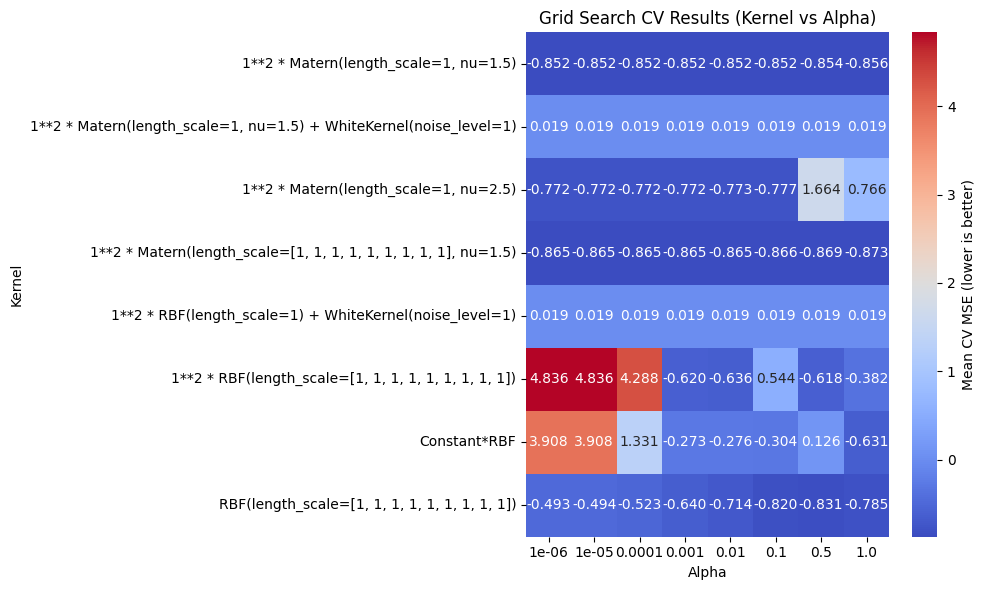

In [254]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract all results from GridSearchCV
cv_results = pd.DataFrame(rgr.cv_results_)

# To properly understand visually flip the sign of the mean test score (since it's negative MSE)
cv_results['mean_R2'] = -cv_results['mean_test_r2']
# Convert kernel objects to strings (so they're easy to plot)
cv_results['param_kernel'] = cv_results['param_kernel'].astype(str)
print(cv_results['param_kernel'].unique())

cv_results['param_kernel'] = cv_results['param_kernel'].replace({
    '1**2': 'ConstantKernel',
    '1**2 * RBF(length_scale=1)': 'Constant*RBF',
    'RBF(length_scale=1)': 'RBF',
    'DotProduct(sigma_0=1)': 'DotProduct',
    'WhiteKernel(noise_level=0.5)': 'WhiteKernel'
})


# Pivot the results: rows=kernels, columns=alpha, values=mean MSE
pivot_table = cv_results.pivot_table(
    values='mean_R2',
    index='param_kernel',
    columns='param_alpha'
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar_kws={'label': 'Mean CV MSE (lower is better)'}
)
plt.title("Grid Search CV Results (Kernel vs Alpha)")
plt.xlabel("Alpha")
plt.ylabel("Kernel")
plt.tight_layout()
plt.show()


# Compute Domain Independent and Domain Specific Model Results

In [255]:
# Using the best values from GridSearchCV to train a final model and test on hold-out test dataset
import numpy as np 
from sklearn.metrics import mean_squared_error, r2_score

# Convert scaled arrays back to DataFrames to preserve feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Predict on training data
y_train_pred = rgr.predict(X_train_scaled_df)
print("\n=== Training Data Performance ===")
print(f"Train MSE:  {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Train R²:   {r2_score(y_train, y_train_pred):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")

# Predict on test data
y_test_pred = rgr.predict(X_test_scaled_df)
print("\n=== Test Data Performance ===")
print(f"Test MSE:  {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Test R²:   {r2_score(y_test, y_test_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")


=== Training Data Performance ===
Train MSE:  0.0526
Train R²:   1.0000
Train RMSE: 0.23

=== Test Data Performance ===
Test MSE:  1242.7858
Test R²:   0.8607
Test RMSE: 35.25


In [256]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor

def plot_gaussian_process_hyperparameter_effects(X_train, y_train, X_test, y_test, parameters):

    # results[kernel][alpha] = (r2, rmse)
    results = {str(kernel): {} for kernel in parameters['kernel']}

    for kernel in parameters['kernel']:
        kernel_name = str(kernel)

        for alpha in parameters['alpha']:
            try:
                gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
                gpr.fit(X_train, y_train)

                y_pred = gpr.predict(X_test)

                r2 = r2_score(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                results[kernel_name][alpha] = (r2, rmse)

            except Exception as e:
                print(f"⚠️ Kernel {kernel_name} failed for alpha={alpha}: {e}")
                results[kernel_name][alpha] = (np.nan, np.nan)

    # ===== PLOT R² =====
    plt.figure(figsize=(10, 6))

    for kernel_name, alpha_dict in results.items():
        alphas = list(alpha_dict.keys())
        r2_vals = [alpha_dict[a][0] for a in alphas]

        plt.plot(alphas, r2_vals, marker='o', label=kernel_name)

    plt.xlabel("alpha")
    plt.ylabel("R² Score")
    plt.title("Effect of alpha and kernel on R² (Gaussian Process Regression)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ===== PLOT RMSE =====
    plt.figure(figsize=(10, 6))

    for kernel_name, alpha_dict in results.items():
        alphas = list(alpha_dict.keys())
        rmse_vals = [alpha_dict[a][1] for a in alphas]

        plt.plot(alphas, rmse_vals, marker='o', label=kernel_name)

    plt.xlabel("alpha")
    plt.ylabel("RMSE")
    plt.title("Effect of alpha and kernel on RMSE (Gaussian Process Regression)")
    plt.grid(True)
    plt.legend()
    plt.show()

    return results


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GaussianProcessR

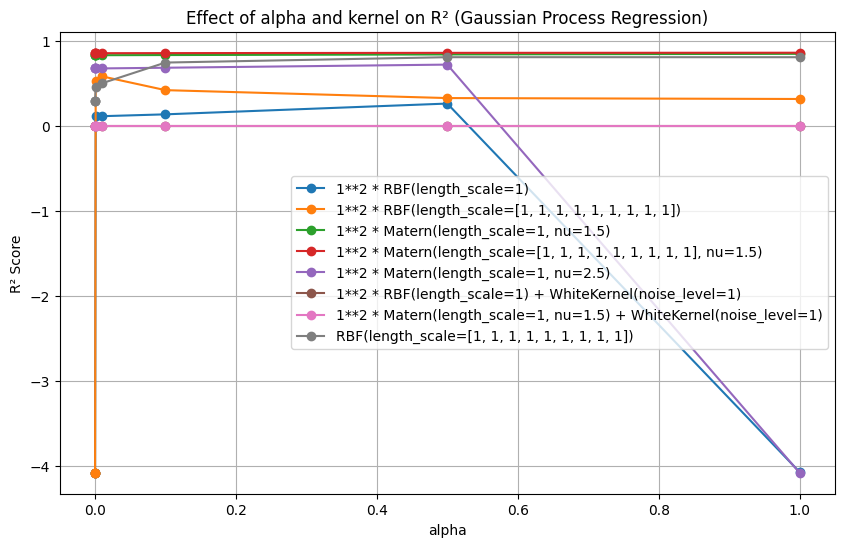

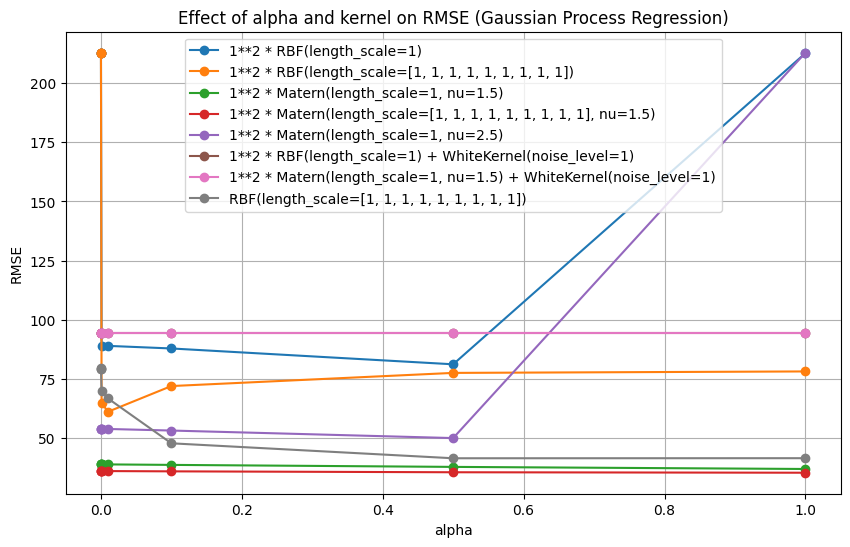

{'1**2 * RBF(length_scale=1)': {1.0: (-4.072147426367137,
   np.float64(212.73486141134006)),
  0.5: (0.262540901717799, np.float64(81.11696621184974)),
  0.1: (0.13573156310536394, np.float64(87.81466664091558)),
  0.01: (0.11399241212455535, np.float64(88.91221942245797)),
  0.001: (0.11191661999861957, np.float64(89.0163129496717)),
  0.0001: (-4.080786371747786, np.float64(212.91595068344617)),
  1e-05: (-4.080786371747786, np.float64(212.91595068344617)),
  1e-06: (-4.080786371747786, np.float64(212.91595068344617))},
 '1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1])': {1.0: (0.31642256879706077,
   np.float64(78.0974022970194)),
  0.5: (0.32719724269490025, np.float64(77.47946476441507)),
  0.1: (0.42039014162296084, np.float64(71.91353083295886)),
  0.01: (0.5825188507973118, np.float64(61.032500834141196)),
  0.001: (0.528908242660993, np.float64(64.83290524589562)),
  0.0001: (-4.080785777314083, np.float64(212.91593822824615)),
  1e-05: (-4.080786371747786, np.float64(21

In [237]:

plot_gaussian_process_hyperparameter_effects(X_train_scaled, y_train, X_test_scaled, y_test, parameters)